# Grad-CAM class activation visualization

**Description:** To obtain a class activation heatmap for an image classification model.

## Importing Libraries

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


## Importing the saved CNN model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GaussianNoise, Rescaling, Resizing

augmentation = Sequential([

    Input(shape=(224, 224, 3)),
    RandomFlip("horizontal"),  # horizontal flips for anatomical realism
    RandomBrightness(factor=0.1),
    RandomRotation((-0.025, 0.025)),  # Small rotations to simulate slight capture variations
    RandomZoom(0.05),  # Minor zoom variations
    RandomTranslation(0.025, 0.025),  # Handle slight misalignments
    GaussianNoise(0.05),  # Add subtle noise for robustness
    Rescaling(1./255)  # Normalize pixel values to [0, 1]

])

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

In [ ]:
# Compiling the model with Adam optimizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001) # Default value

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # for multi-class classification
              metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
model.summary()

In [ ]:
model.load_weights('/content/drive/MyDrive/AI_project/Models/cnn_classifier2.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.build(input_shape=(None, 224, 224, 3))

## Preprocssing and viewing sample images

In [ ]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [ ]:
img_path = "/content/drive/MyDrive/AI_project/eye-images/2_cataract/cataract_017.png"
display(Image(img_path))

#img = preprocess_image(img_path)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Prepare image
img_array = preprocess_image(img_path)

# Print what the two top predicted classes are
preds = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
img_array.shape

(1, 224, 224, 3)

In [ ]:
preds

array([[0.00584339, 0.9930184 , 0.00113816]], dtype=float32)

Based on the prediction probabilities, the model predicted the class of the image correctly, i.e., Cataract. This would be expected as the model has the best performance for cataract.

In [ ]:
preds.shape

(1, 3)

In [ ]:
model.layers

[<Sequential name=sequential, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <MaxPooling2D name=max_pooling2d_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <MaxPooling2D name=max_pooling2d_4, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
last_conv_layer_name = 'conv2d_4'

In [ ]:
grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.outputs[0]]
    )
grad_model.summary()

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    print(last_conv_layer_output.shape)
    print(preds.shape)
    pred_index = tf.argmax(preds[0])
    print(pred_index)
    class_channel = preds[:, pred_index]
    print(class_channel.shape)
    print(class_channel)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

(512,)


In [ ]:
def make_gradcam_heatmap2(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.outputs[0]]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_array = preprocess_image(img_path)

# Print what the two top predicted classes are
preds = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_741']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


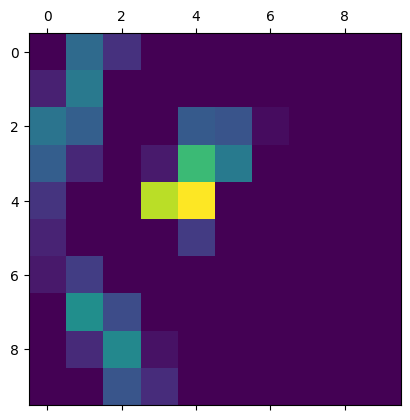

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap2(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
import tensorflow as tf
from PIL import Image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("summer_r")

    # Create an image with RGB colorized heatmap
    jet_heatmap = jet(heatmap)[:, :, :3]  # Remove alpha channel
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img / 255.0, 0, 1)  # Normalize for display

    # Display the image and heatmap with color bar
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(superimposed_img)
    ax.axis("off")  # Hide axes

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap="summer_r", norm=plt.Normalize(vmin=0, vmax=1))
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Activation Intensity")

    plt.show()


<ipython-input-178-d76910566687>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("summer_r")


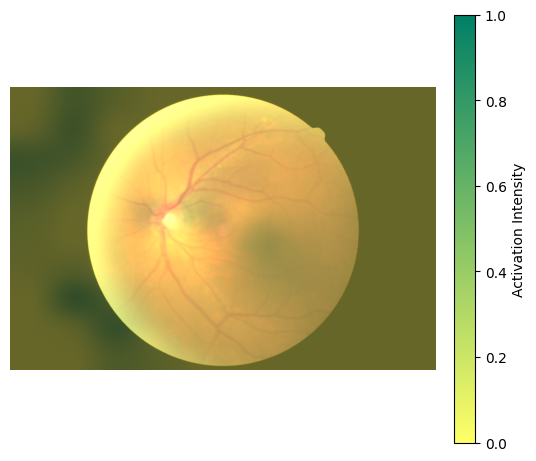

In [ ]:
save_and_display_gradcam(img_path, heatmap)

In [ ]:
!apt-get update
!apt-get install -y pandoc
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [7]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/GradCAM_CNN.ipynb' --allow-chromium-download

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/GradCAM_CNN.ipynb to pdf
[NbConvertApp] Support files will be in GradCAM_CNN_files/
[NbConvertApp] Making directory ./GradCAM_CNN_files
[NbConvertApp] Writing 50485 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 167226 bytes to /content/drive/MyDrive/Colab Notebooks/GradCAM_CNN.pdf
